1. (20) Build a model for the algae data set used in HW3. You model should
include all 11 variables. Obtain estimates for the model parameters using

*   a) variational approximation with Automatic Differentiation Variational
Inference (ADVI);

*   b) variational approximation with Stein Variational
Gradient Descent (SVGD); and

*   c) sampling approximation using the No
U-turn Sampler (NUTS). For each method show the estimated posterior
distributions for the parameters and show graphs of convergence.
* Finally discuss similarities and differences in the estimates provided by each
method.



  

In [20]:
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np
import seaborn as sns



In [21]:
from google.colab import files
uploaded = files.upload()


Saving algae.csv to algae (1).csv


In [22]:
algae_train = pd.read_csv('algae.csv')

predictors = algae_train.columns[0:11]
for p in predictors:
  sum_stats = (algae_train.loc[:, [p, 'a1']].groupby(p).agg(["mean", "std", "count"]))
  #print(sum_stats)


In [23]:
#drop unneeded vars
algae_train.drop(['a2','a3','a4','a5','a6','a7'], axis = 1, inplace = True)

In [24]:
algae_train

,season,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,a1
0,winter,small,medium,8.00,9.8,60.800,6.238,578.00000,105.000,170.00000,50.000,0.0
1,spring,small,medium,8.35,8.0,57.750,1.288,370.00000,428.750,558.75000,1.300,1.4
2,autumn,small,medium,8.10,11.4,40.020,5.330,346.66699,125.667,187.05701,15.600,3.3
3,spring,small,medium,8.07,4.8,77.364,2.302,98.18200,61.182,138.70000,1.400,3.1
4,autumn,small,medium,8.06,9.0,55.350,10.416,233.70000,58.222,97.58000,10.500,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...
195,autumn,large,medium,8.40,8.4,17.375,3.833,83.75000,53.625,79.75000,2.338,12.7
196,spring,large,medium,8.30,10.6,14.320,3.200,125.33300,35.333,75.90400,4.667,18.0
197,autumn,large,medium,8.20,7.0,139.989,2.978,60.11000,78.333,140.22000,31.738,0.0
198,winter,large,medium,8.00,7.6,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [25]:
# there are no discrete columns, and the categorical columns have no missing data
for col in predictors[3:]:
  algae_train[col] = algae_train[col].replace(np.nan, np.mean(algae_train[col]))
  algae_train[col] -= np.mean(algae_train[col])
  algae_train[col] /= np.std(algae_train[col])
season_vals = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}
size_vals = {'small': 0, 'medium': 1, 'large': 2}
speed_vals = {'low': 0, 'medium': 1, 'high': 2}
algae_train['season'] = algae_train['season'].replace(season_vals)
algae_train['size'] = algae_train['size'].replace(size_vals)
algae_train['speed'] = algae_train['speed'].replace(speed_vals)

algae_train['a1'].loc[algae_train['a1']>0] = np.log(algae_train['a1'].loc[algae_train['a1']>0])

<ipython-input-25-ce9099891a6c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  algae_train['a1'].loc[algae_train['a1']>0] = np.log(algae_train['a1'].loc[algae_train['a1']>0])


In [26]:
pd.isnull(algae_train).any()
random_seed=1234

array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta3'}>],
       [<Axes: title={'center': 'beta4'}>,
        <Axes: title={'center': 'beta4'}>],
       [<Axes: title={'center': 'beta5'}>,
        <Axes: title={'center': 'beta5'}>],
       [<Axes: title={'center': 'beta6'}>,
        <Axes: title={'center': 'beta6'}>],
       [<Axes: title={'center': 'beta7'}>,
        <Axes: title={'center': 'beta7'}>],
       [<Axes: title={'center': 'beta8'}>,
        <Axes: title={'center': 'beta8'}>],
       [<Axes: title={'center': 'beta9'}>,
        <Axes: title={'center': 'beta9'}>],
       [<Axes: title={'center': 'beta10'}>,
        <Axes: title={'center': 'beta10'}>],
       [<Axes: title={'center': 'beta11'}

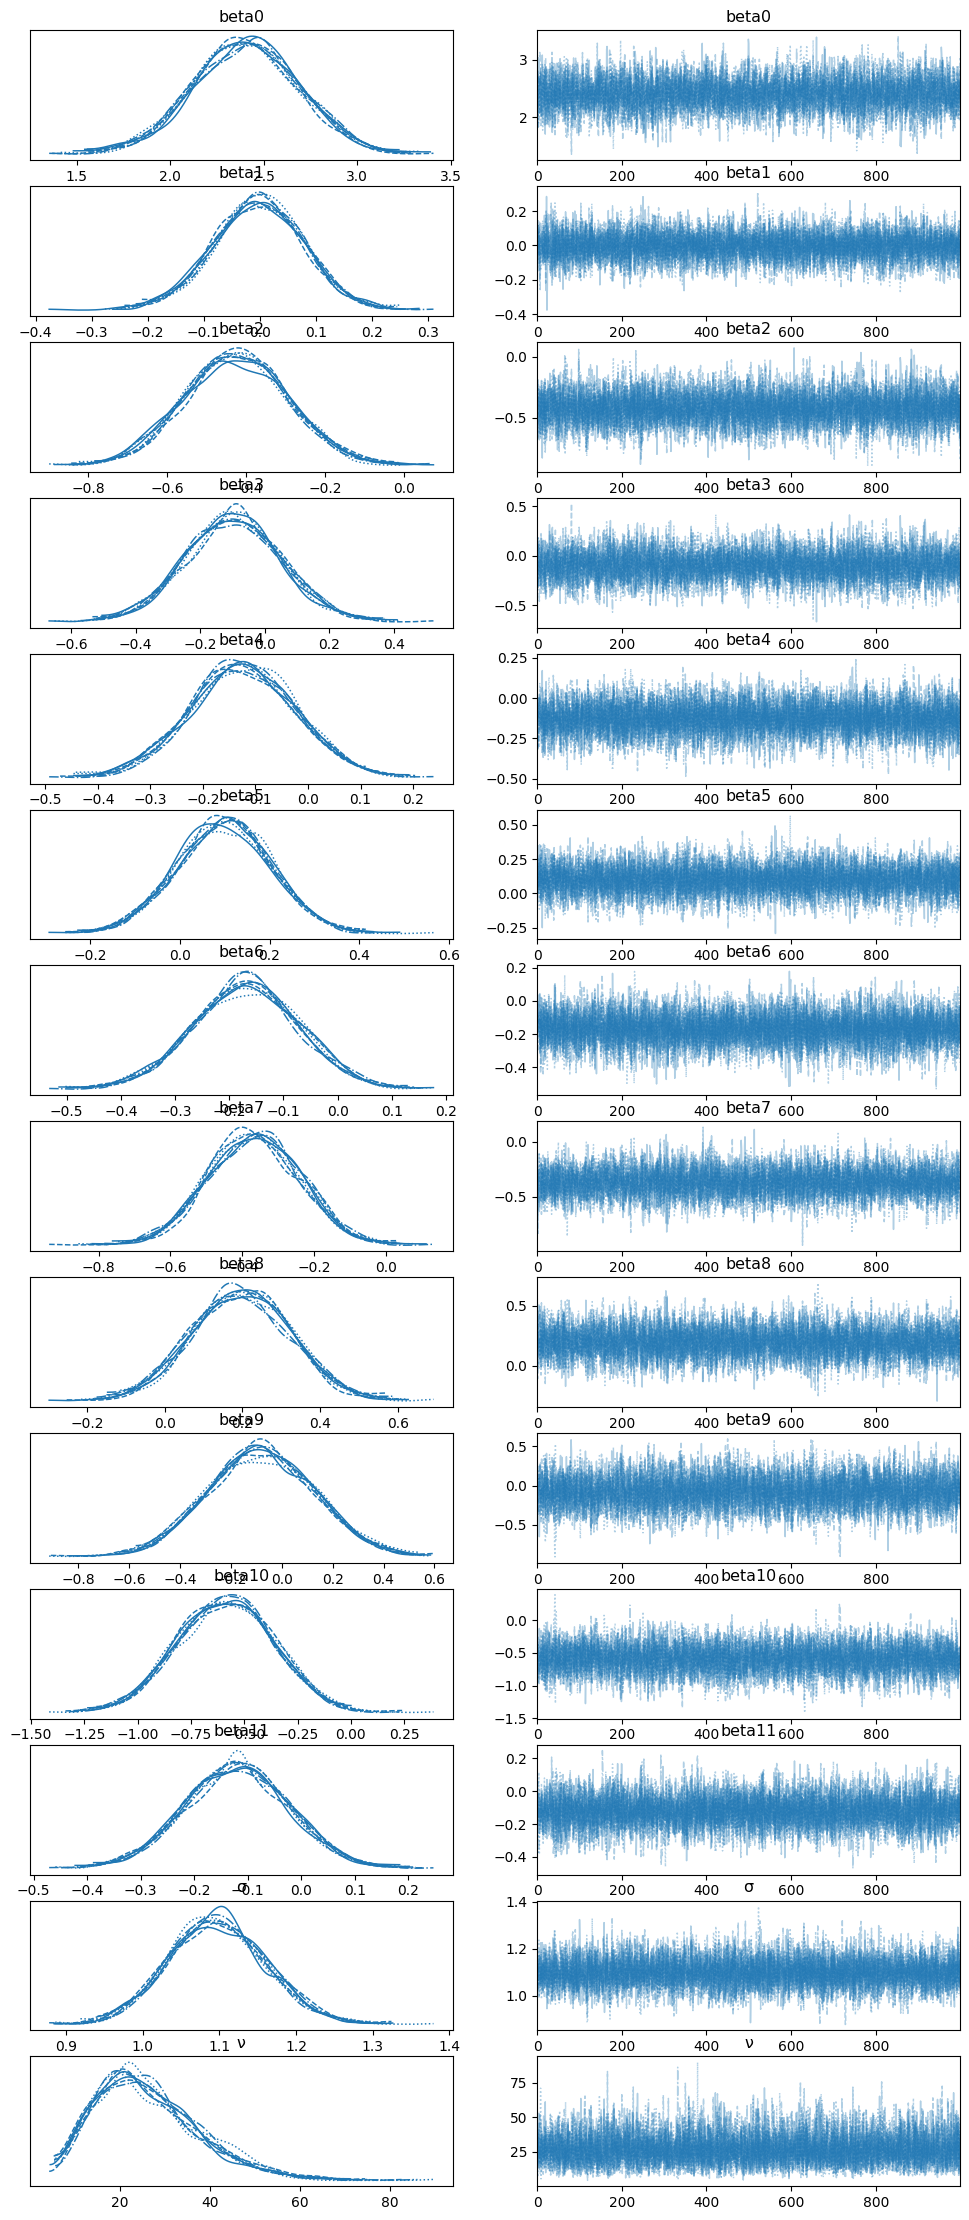

In [27]:
with pm.Model() as robust:
  beta0 = pm.Normal('beta0', mu=0, sigma=10)
  beta1 = pm.Normal('beta1', mu=0, sigma=10)
  beta2 = pm.Normal('beta2', mu=0, sigma=10)
  beta3 = pm.Normal('beta3', mu=0, sigma=10)
  beta4 = pm.Normal('beta4', mu=0, sigma=10)
  beta5 = pm.Normal('beta5', mu=0, sigma=10)
  beta6 = pm.Normal('beta6', mu=0, sigma=10)
  beta7 = pm.Normal('beta7', mu=0, sigma=10)
  beta8 = pm.Normal('beta8', mu=0, sigma=10)
  beta9 = pm.Normal('beta9', mu=0, sigma=10)
  beta10 = pm.Normal('beta10', mu=0, sigma=10)
  beta11 = pm.Normal('beta11', mu=0, sigma=10)


  σ = pm.Uniform("σ", 10**-5, 10)
  ν = pm.HalfNormal("ν", 20)

  ph = pm.MutableData("ph", algae_train.iloc[:,3])
  mn = pm.MutableData("mn", algae_train.iloc[:,4])
  cl = pm.MutableData("cl", algae_train.iloc[:,5])
  no3 = pm.MutableData("no3", algae_train.iloc[:,6])
  nh4 = pm.MutableData("nh4", algae_train.iloc[:,7])
  opo4 = pm.MutableData("opo4", algae_train.iloc[:,8])
  po4 = pm.MutableData("po4", algae_train.iloc[:,9])
  chla = pm.MutableData("chla", algae_train.iloc[:,10])

  μ = pm.Deterministic("μ", beta0 + beta1*algae_train.iloc[:, 0] + beta2*algae_train.iloc[:, 1] + beta3*algae_train.iloc[:, 2] + beta4*ph
                       + beta5*mn + beta6*cl + beta7*no3 + beta8*nh4 + beta9*opo4
                        + beta10*po4 + beta11*chla)

  alg = pm.StudentT('a1', mu=μ, sigma=σ, nu=ν,observed=algae_train['a1'])
  trace = pm.sample(cores = 8, return_inferencedata = False, random_seed=1234)
  trace_robust = pm.to_inference_data(trace=trace, log_likelihood=True)
  robust_pp = pm.sample_posterior_predictive(trace_robust, extend_inferencedata=True,
                                   random_seed=1234)
  y_pred_test = robust_pp['posterior_predictive']['a1']
az.plot_trace(trace_robust, var_names=["beta0", "beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9", "beta10",
                                      "beta11","σ", "ν"])

<Axes: title={'center': 'a1 / a1'}>

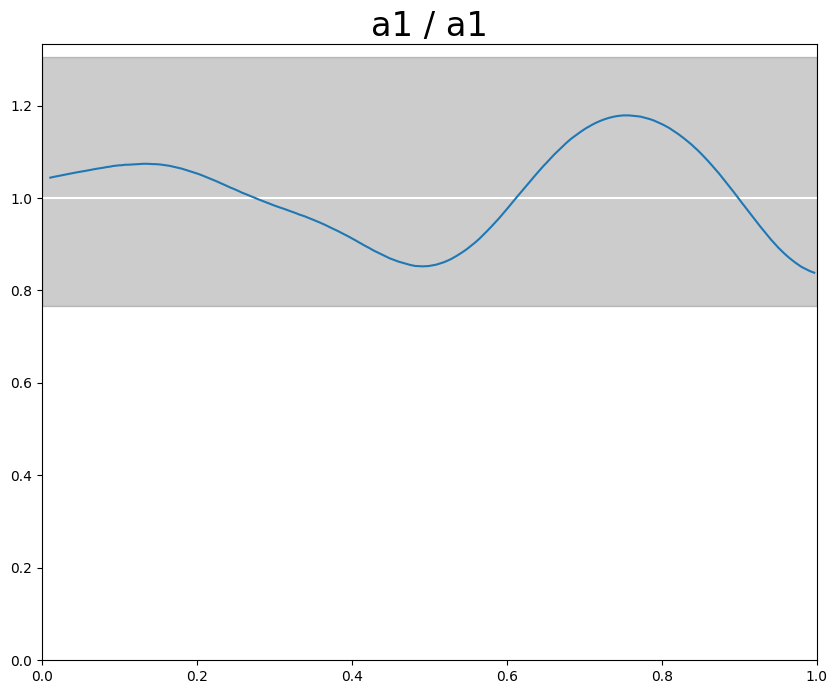

In [28]:
az.plot_bpv(trace_robust, figsize = (10,8))

In [29]:
# Part C: NUTS
algae_hmc_trace = pm.sample(10000, model = robust, random_seed = random_seed, cores = 8)


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

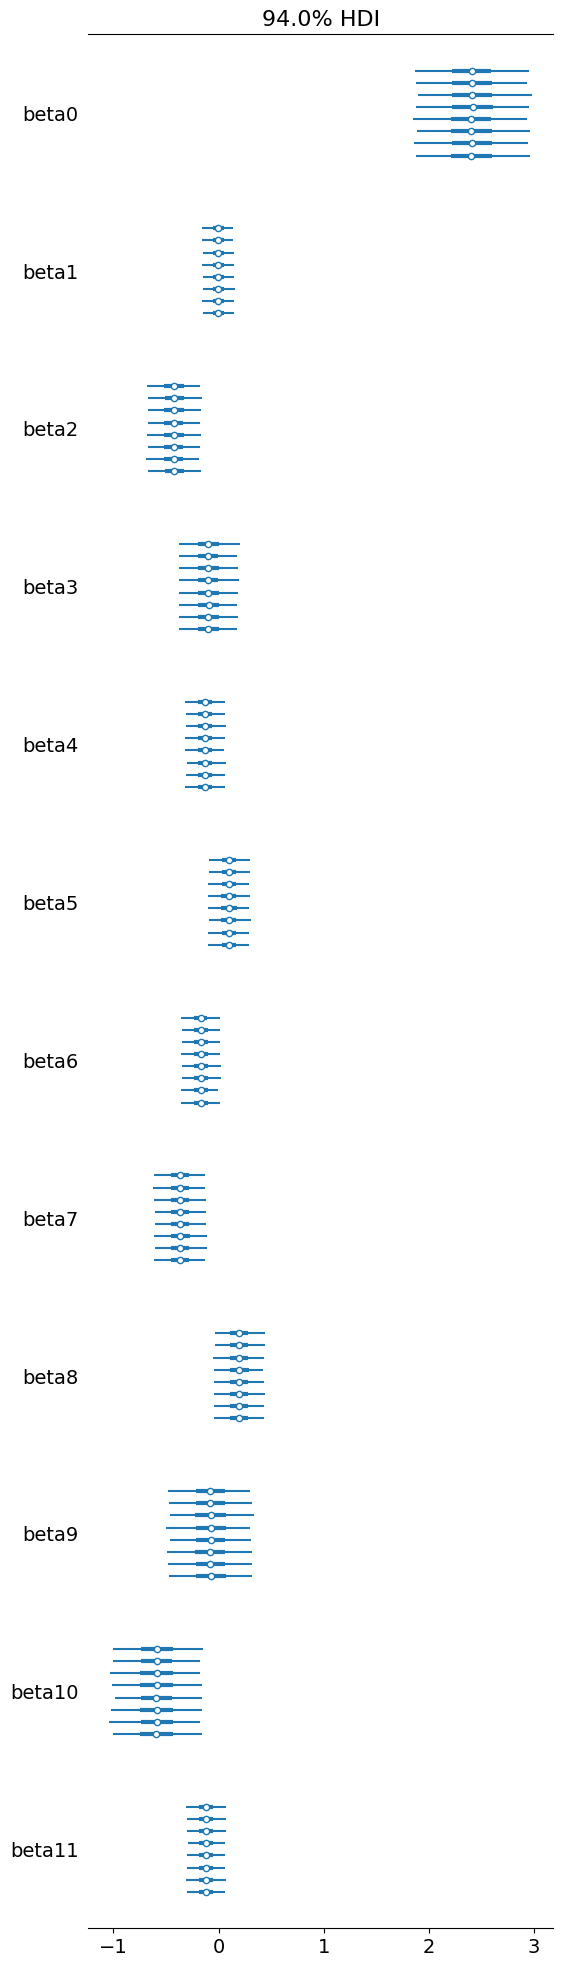

In [30]:
az.plot_forest(algae_hmc_trace, var_names=['beta0', 'beta1','beta2', 'beta3', 'beta4','beta5','beta6','beta7','beta8','beta9','beta10','beta11'])


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta4'}>,
        <Axes: title={'center': 'beta5'}>],
       [<Axes: title={'center': 'beta6'}>,
        <Axes: title={'center': 'beta7'}>,
        <Axes: title={'center': 'beta8'}>],
       [<Axes: title={'center': 'beta9'}>,
        <Axes: title={'center': 'beta10'}>,
        <Axes: title={'center': 'beta11'}>]], dtype=object)

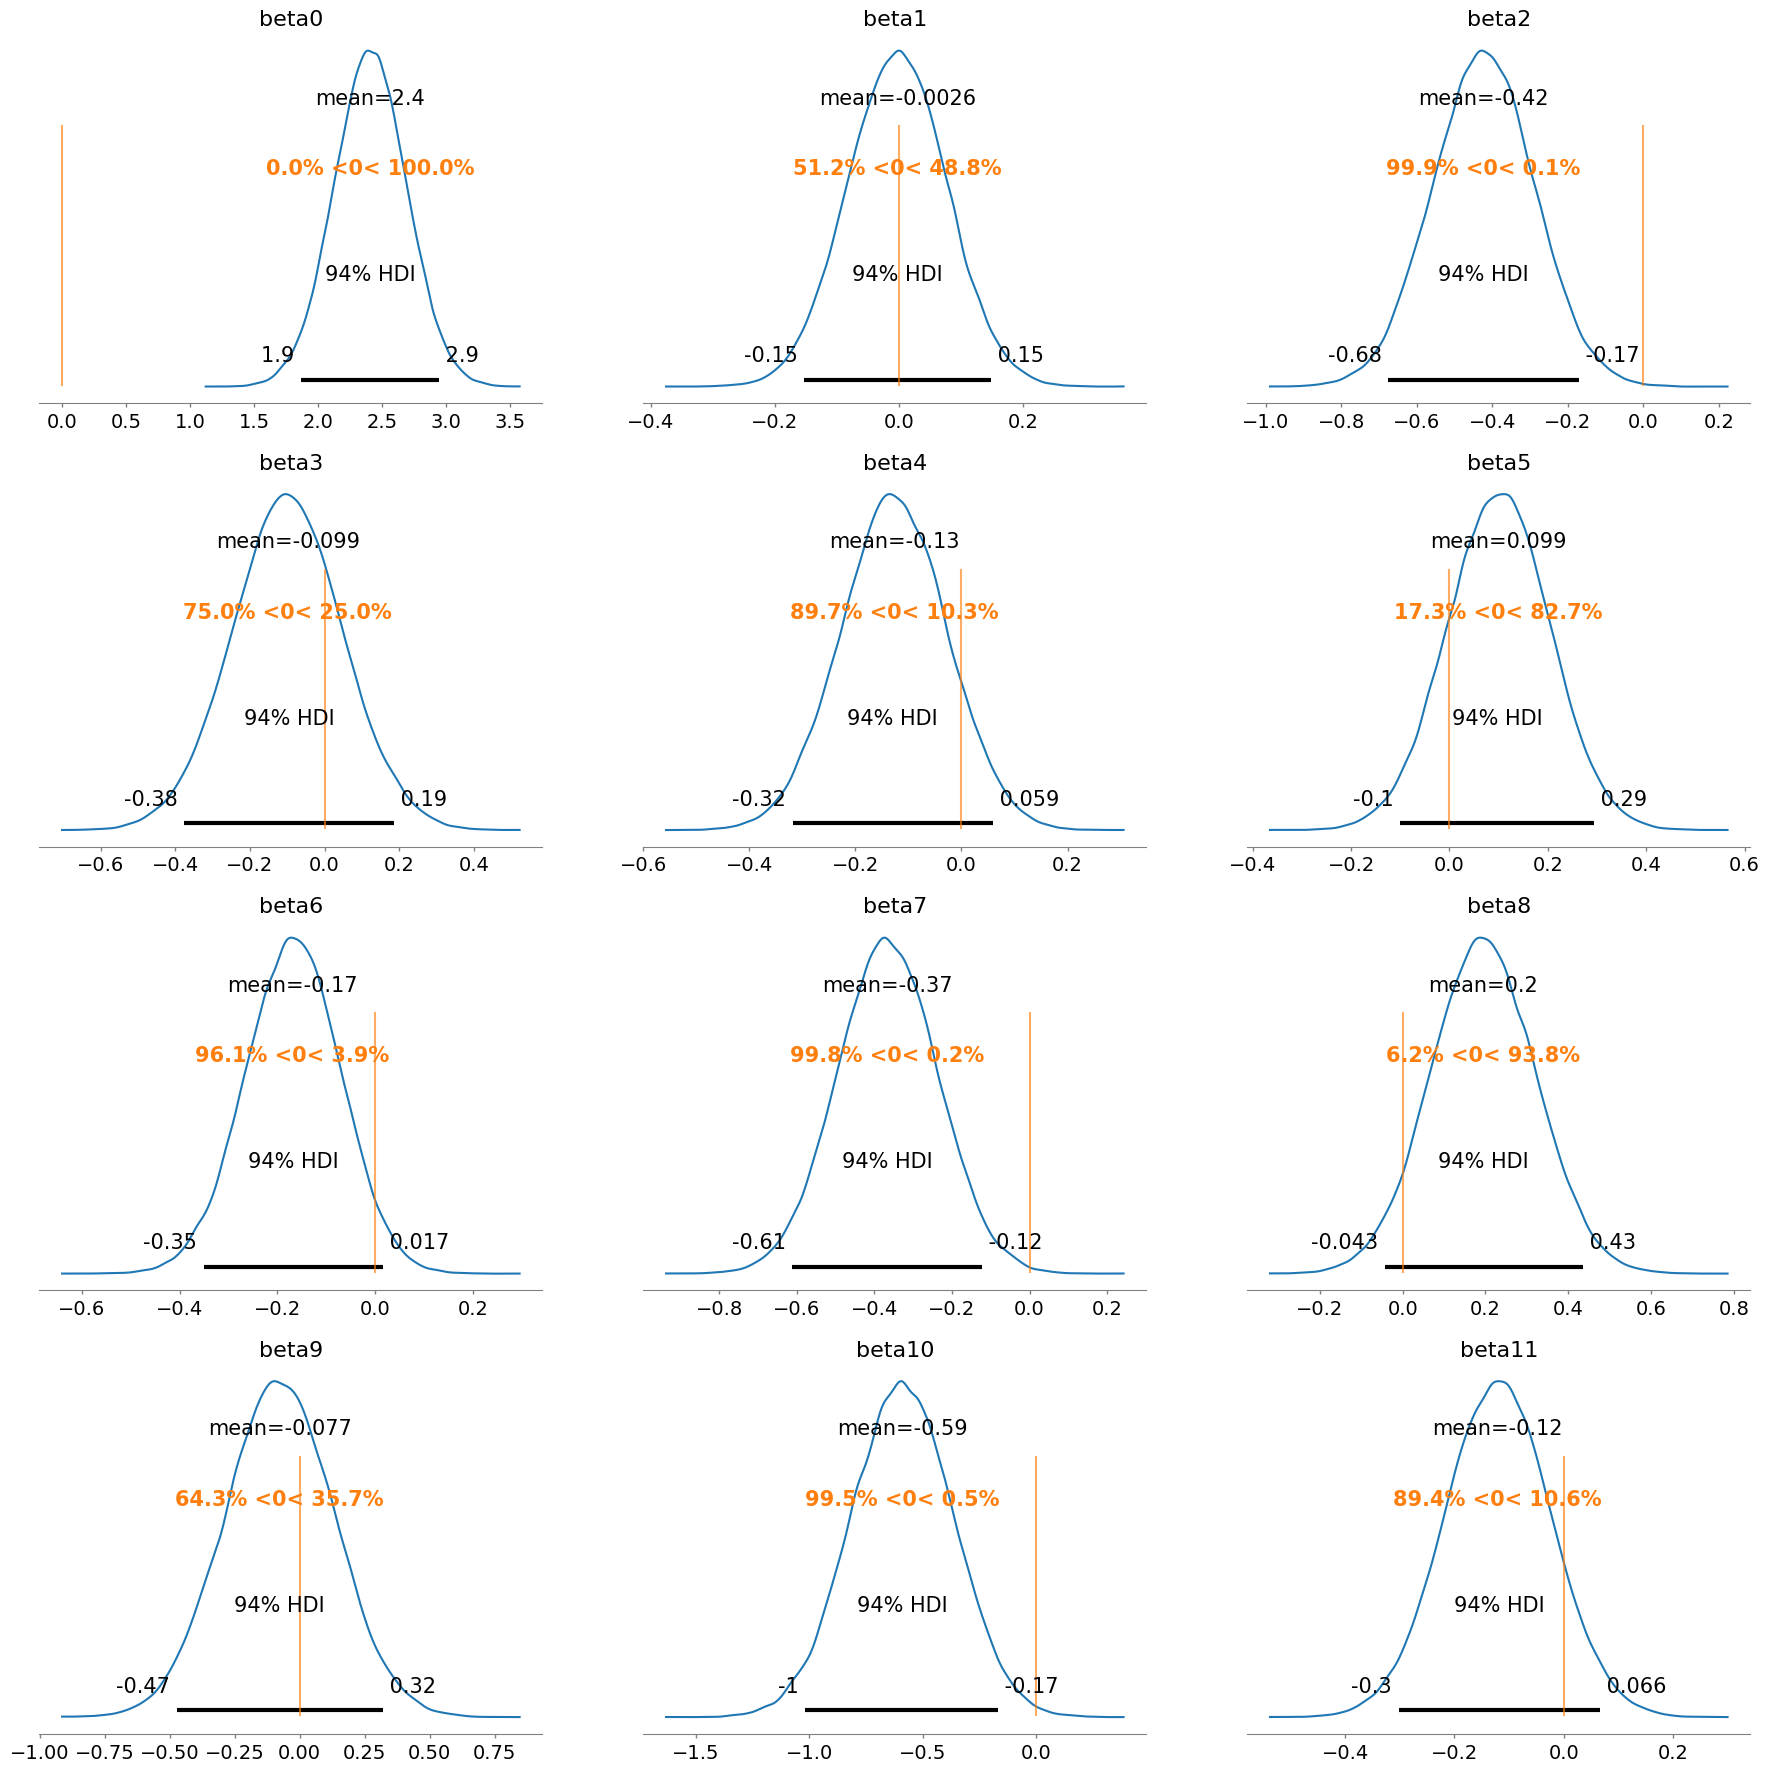

In [31]:
az.plot_posterior(
    algae_hmc_trace,
    var_names=['beta0', 'beta1','beta2', 'beta3', 'beta4','beta5','beta6','beta7','beta8','beta9','beta10','beta11'], ref_val = 0
)


In [32]:
# Part a) ADVI

with robust:
    # Variational fit with ADVI optimization
    advi_fit = pm.fit(50000, method='advi', random_seed = random_seed)

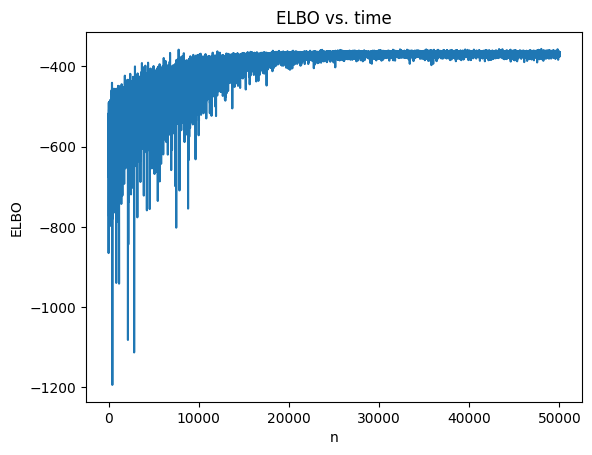

In [33]:
advi_elbo = pd.DataFrame(
    {'ELBO': -advi_fit.hist,
     'n': np.arange(advi_fit.hist.shape[0])})

plt.figure(dpi=100)
ax = sns.lineplot(y='ELBO', x='n', data=advi_elbo)
ax.set_title("ELBO vs. time")
plt.show()

In [34]:
advi_samples = 5000
algae_advi_trace = advi_fit.sample(advi_samples)

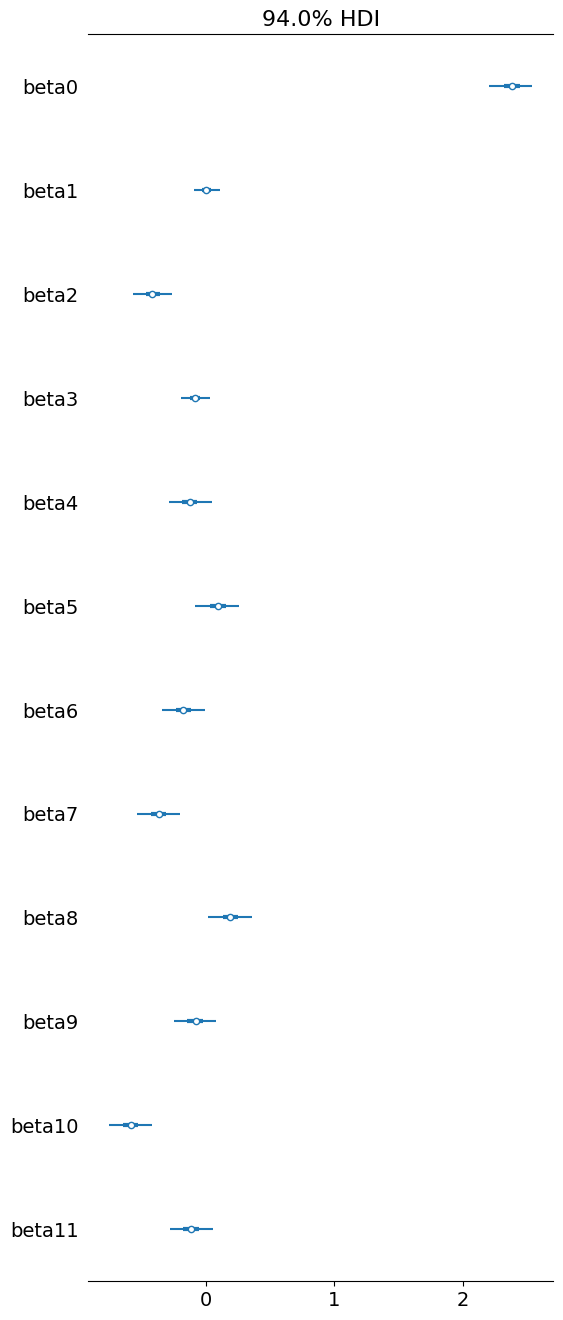

In [35]:
#taking a look at the distribution of each predictor.
with robust:
    az.plot_forest(algae_advi_trace, var_names=['beta0', 'beta1','beta2', 'beta3', 'beta4','beta5','beta6','beta7','beta8','beta9','beta10','beta11'])


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta4'}>,
        <Axes: title={'center': 'beta5'}>],
       [<Axes: title={'center': 'beta6'}>,
        <Axes: title={'center': 'beta7'}>,
        <Axes: title={'center': 'beta8'}>],
       [<Axes: title={'center': 'beta9'}>,
        <Axes: title={'center': 'beta10'}>,
        <Axes: title={'center': 'beta11'}>]], dtype=object)

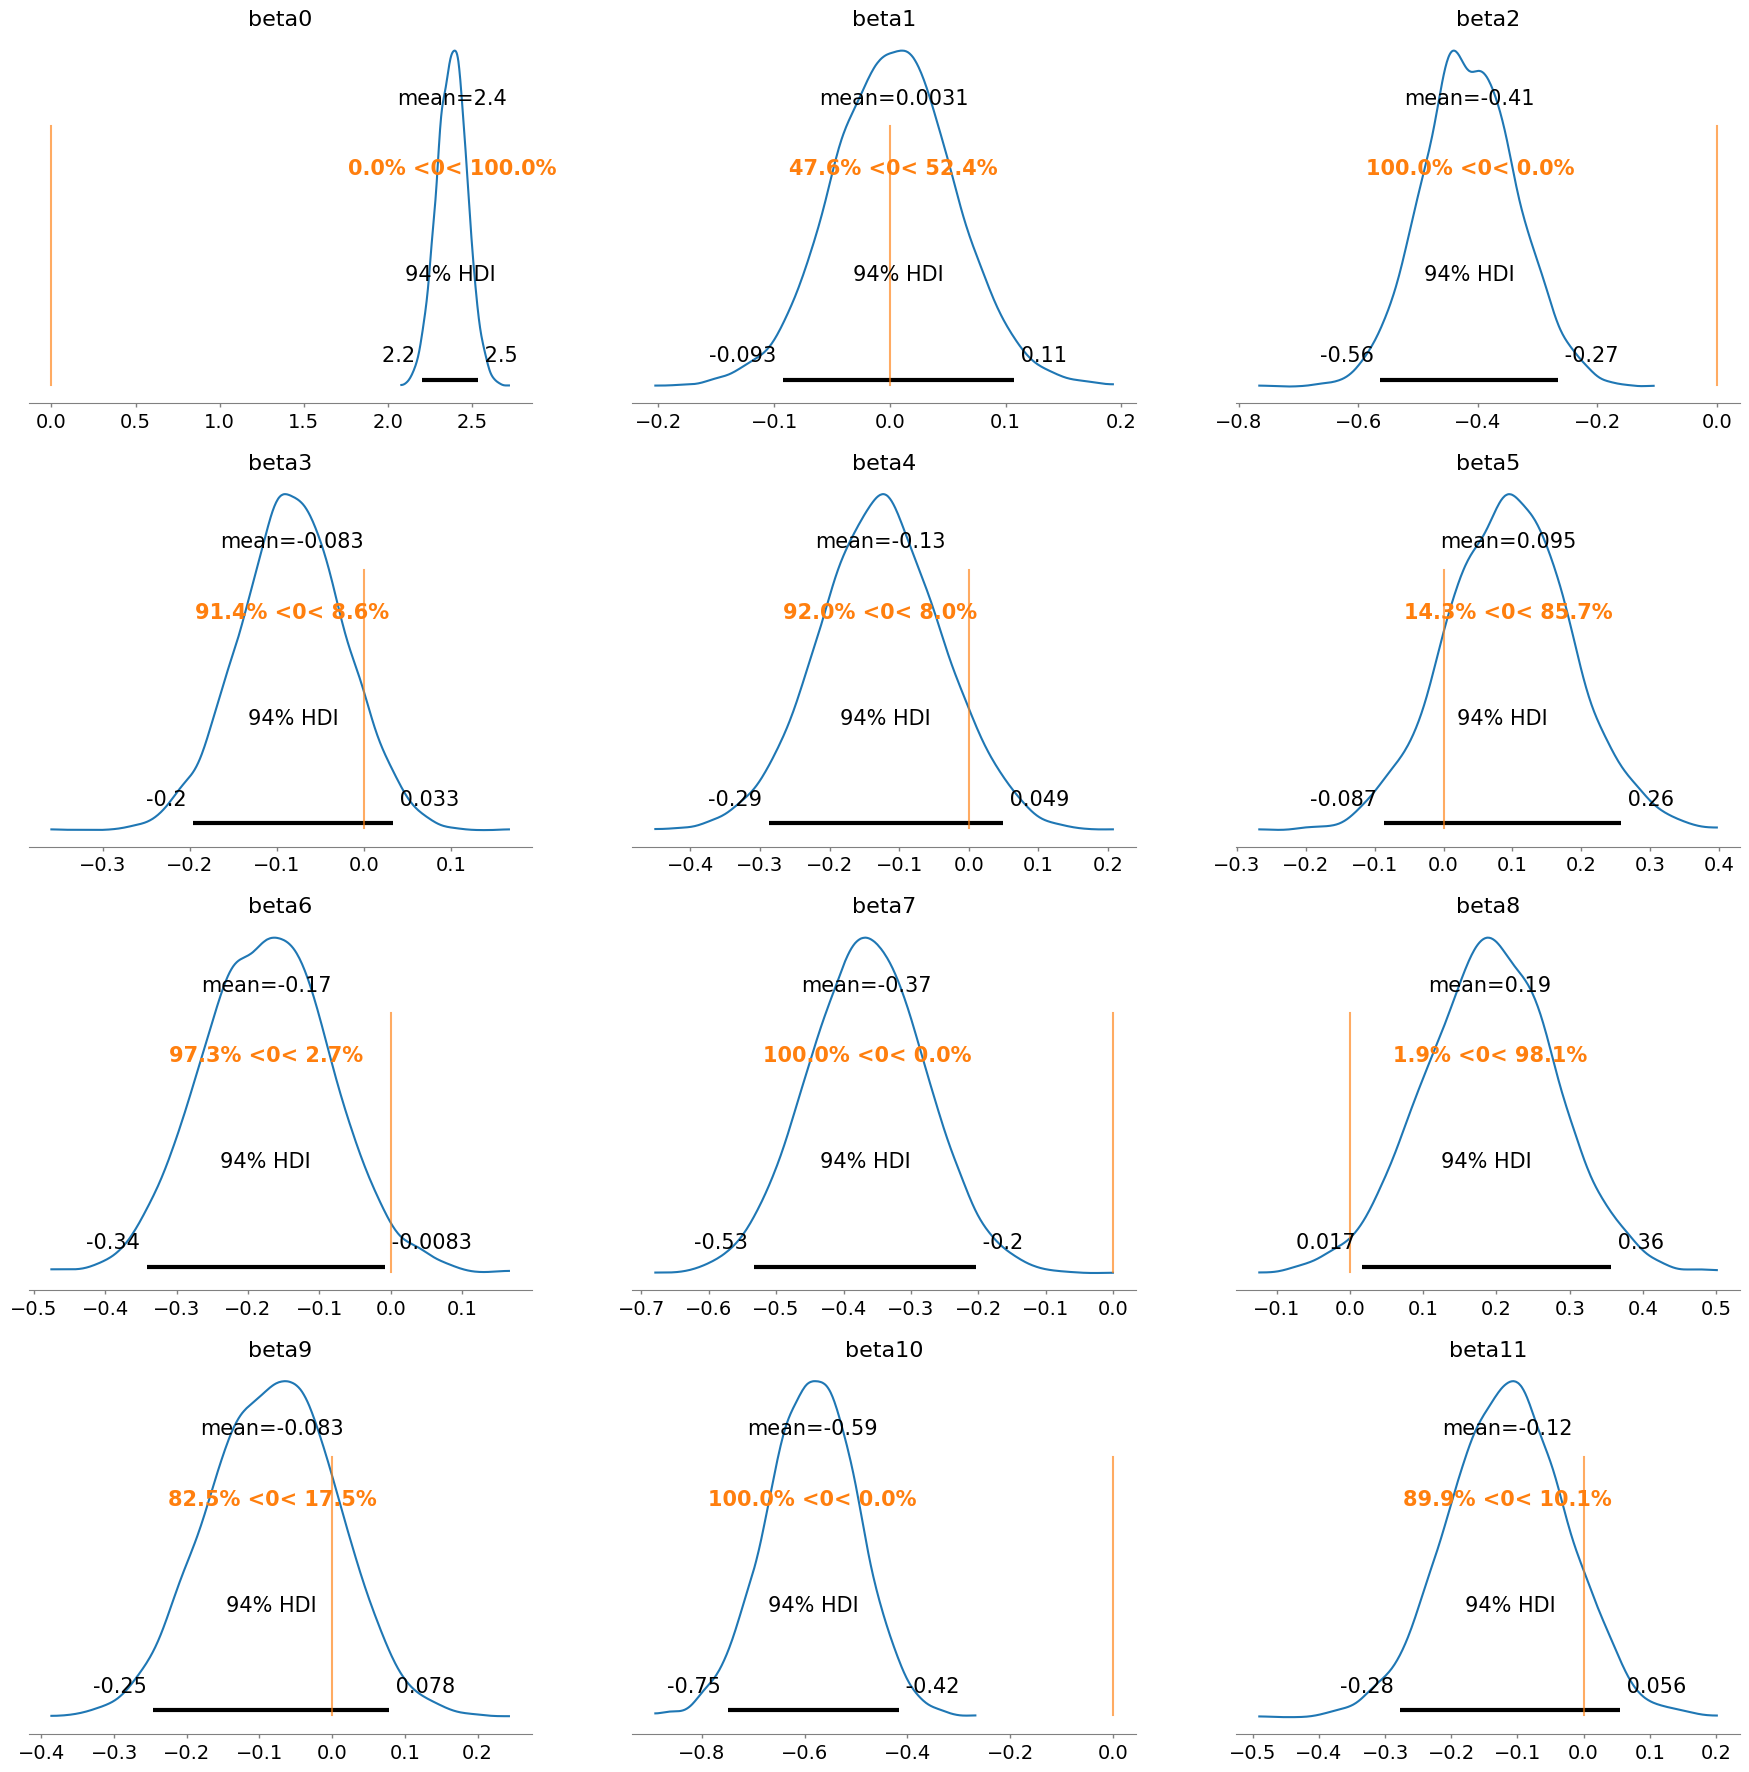

In [36]:
az.plot_posterior(
    algae_advi_trace,
    var_names=['beta0', 'beta1','beta2', 'beta3', 'beta4','beta5','beta6','beta7','beta8','beta9','beta10','beta11'], ref_val = 0
)


In [37]:
# Part B) Obtain the variational fit with svgd

with robust:
    svgd_approx = pm.SVGD(n_particles=500, jitter=1)



In [39]:
tracker = pm.callbacks.Tracker(
    mean=svgd_approx.approx.mean.eval,  # callable that returns mean
    std=svgd_approx.approx.std.eval,  # callable that returns std
    )


In [40]:
approx = svgd_approx.fit(2000,
                         callbacks=[tracker])

Text(0.5, 1.0, 'Std track')

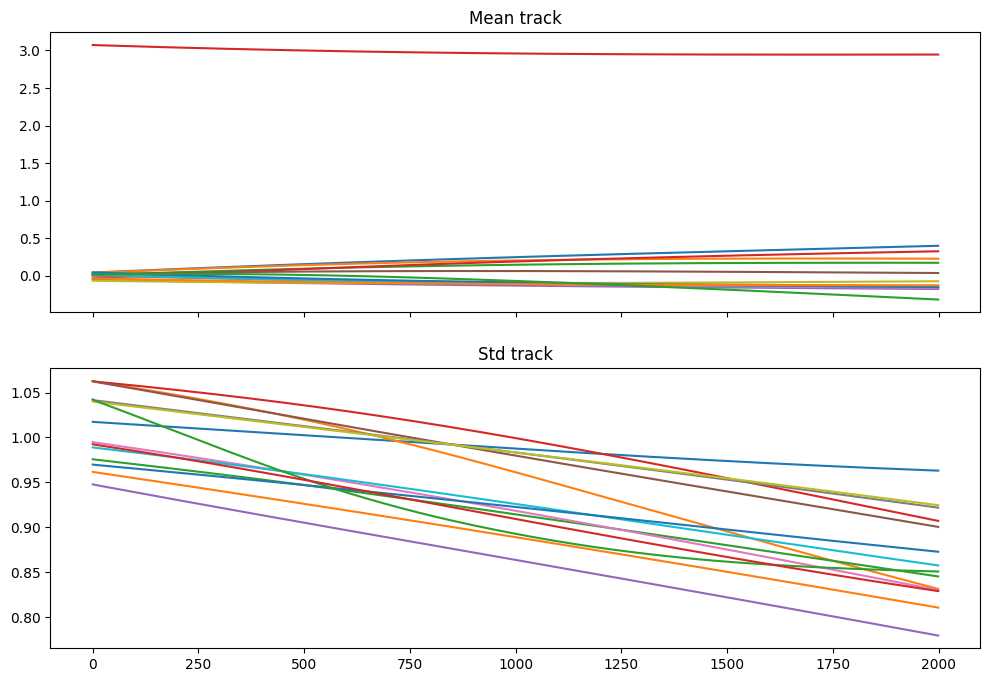

In [41]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(12, 8))
ax1.plot(tracker["mean"])
ax1.set_title("Mean track")
ax2.plot(tracker["std"])
ax2.set_title("Std track")


In [42]:
# getting the variational fit for svgd with different learning rate
approx = svgd_approx.fit(2000,
                         callbacks=[tracker],
                         obj_optimizer=pm.adamax(learning_rate=0.1))

Text(0.5, 1.0, 'Std track')

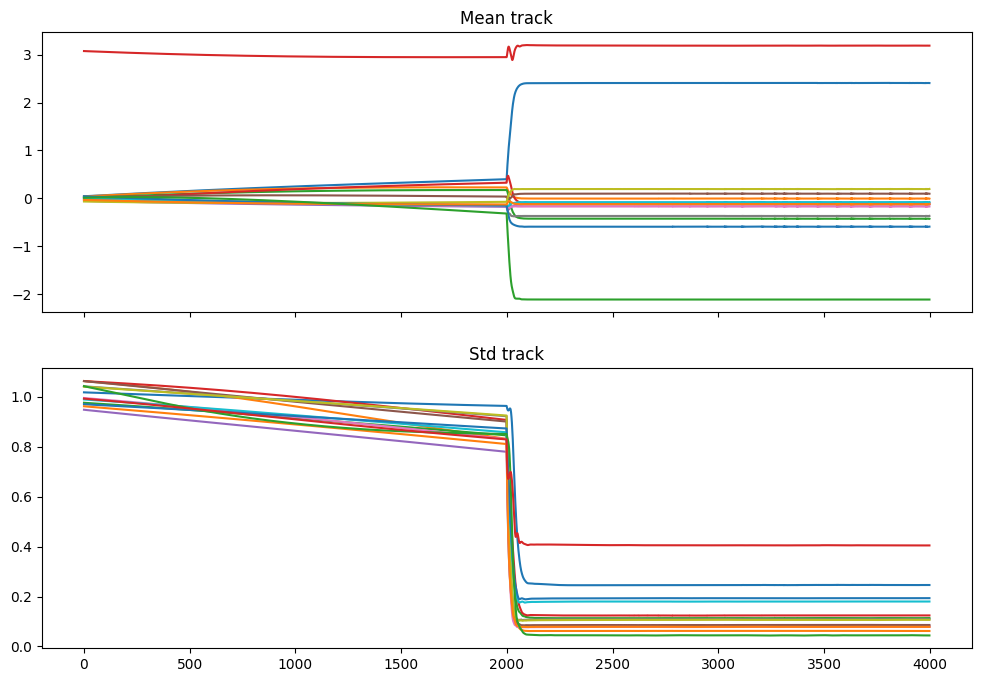

In [43]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex = True, figsize=(12, 8))
ax1.plot(tracker["mean"])
ax1.set_title("Mean track")
ax2.plot(tracker["std"])
ax2.set_title("Std track")


In [44]:
# sample from the variational posterior distribution
svgd_samples = 5000
algae_svgd_trace = approx.sample(svgd_samples)

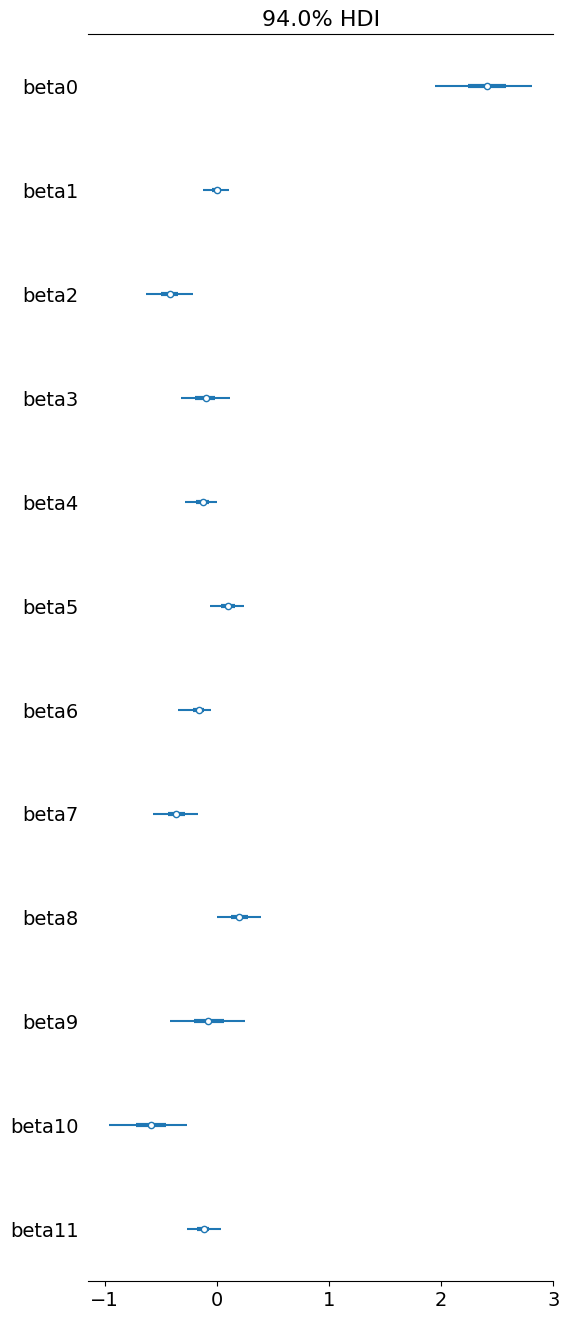

In [45]:
with robust:
    az.plot_forest(algae_svgd_trace, var_names = ['beta0', 'beta1','beta2', 'beta3', 'beta4','beta5','beta6','beta7','beta8','beta9','beta10','beta11'])


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta2'}>],
       [<Axes: title={'center': 'beta3'}>,
        <Axes: title={'center': 'beta4'}>,
        <Axes: title={'center': 'beta5'}>],
       [<Axes: title={'center': 'beta6'}>,
        <Axes: title={'center': 'beta7'}>,
        <Axes: title={'center': 'beta8'}>],
       [<Axes: title={'center': 'beta9'}>,
        <Axes: title={'center': 'beta10'}>,
        <Axes: title={'center': 'beta11'}>]], dtype=object)

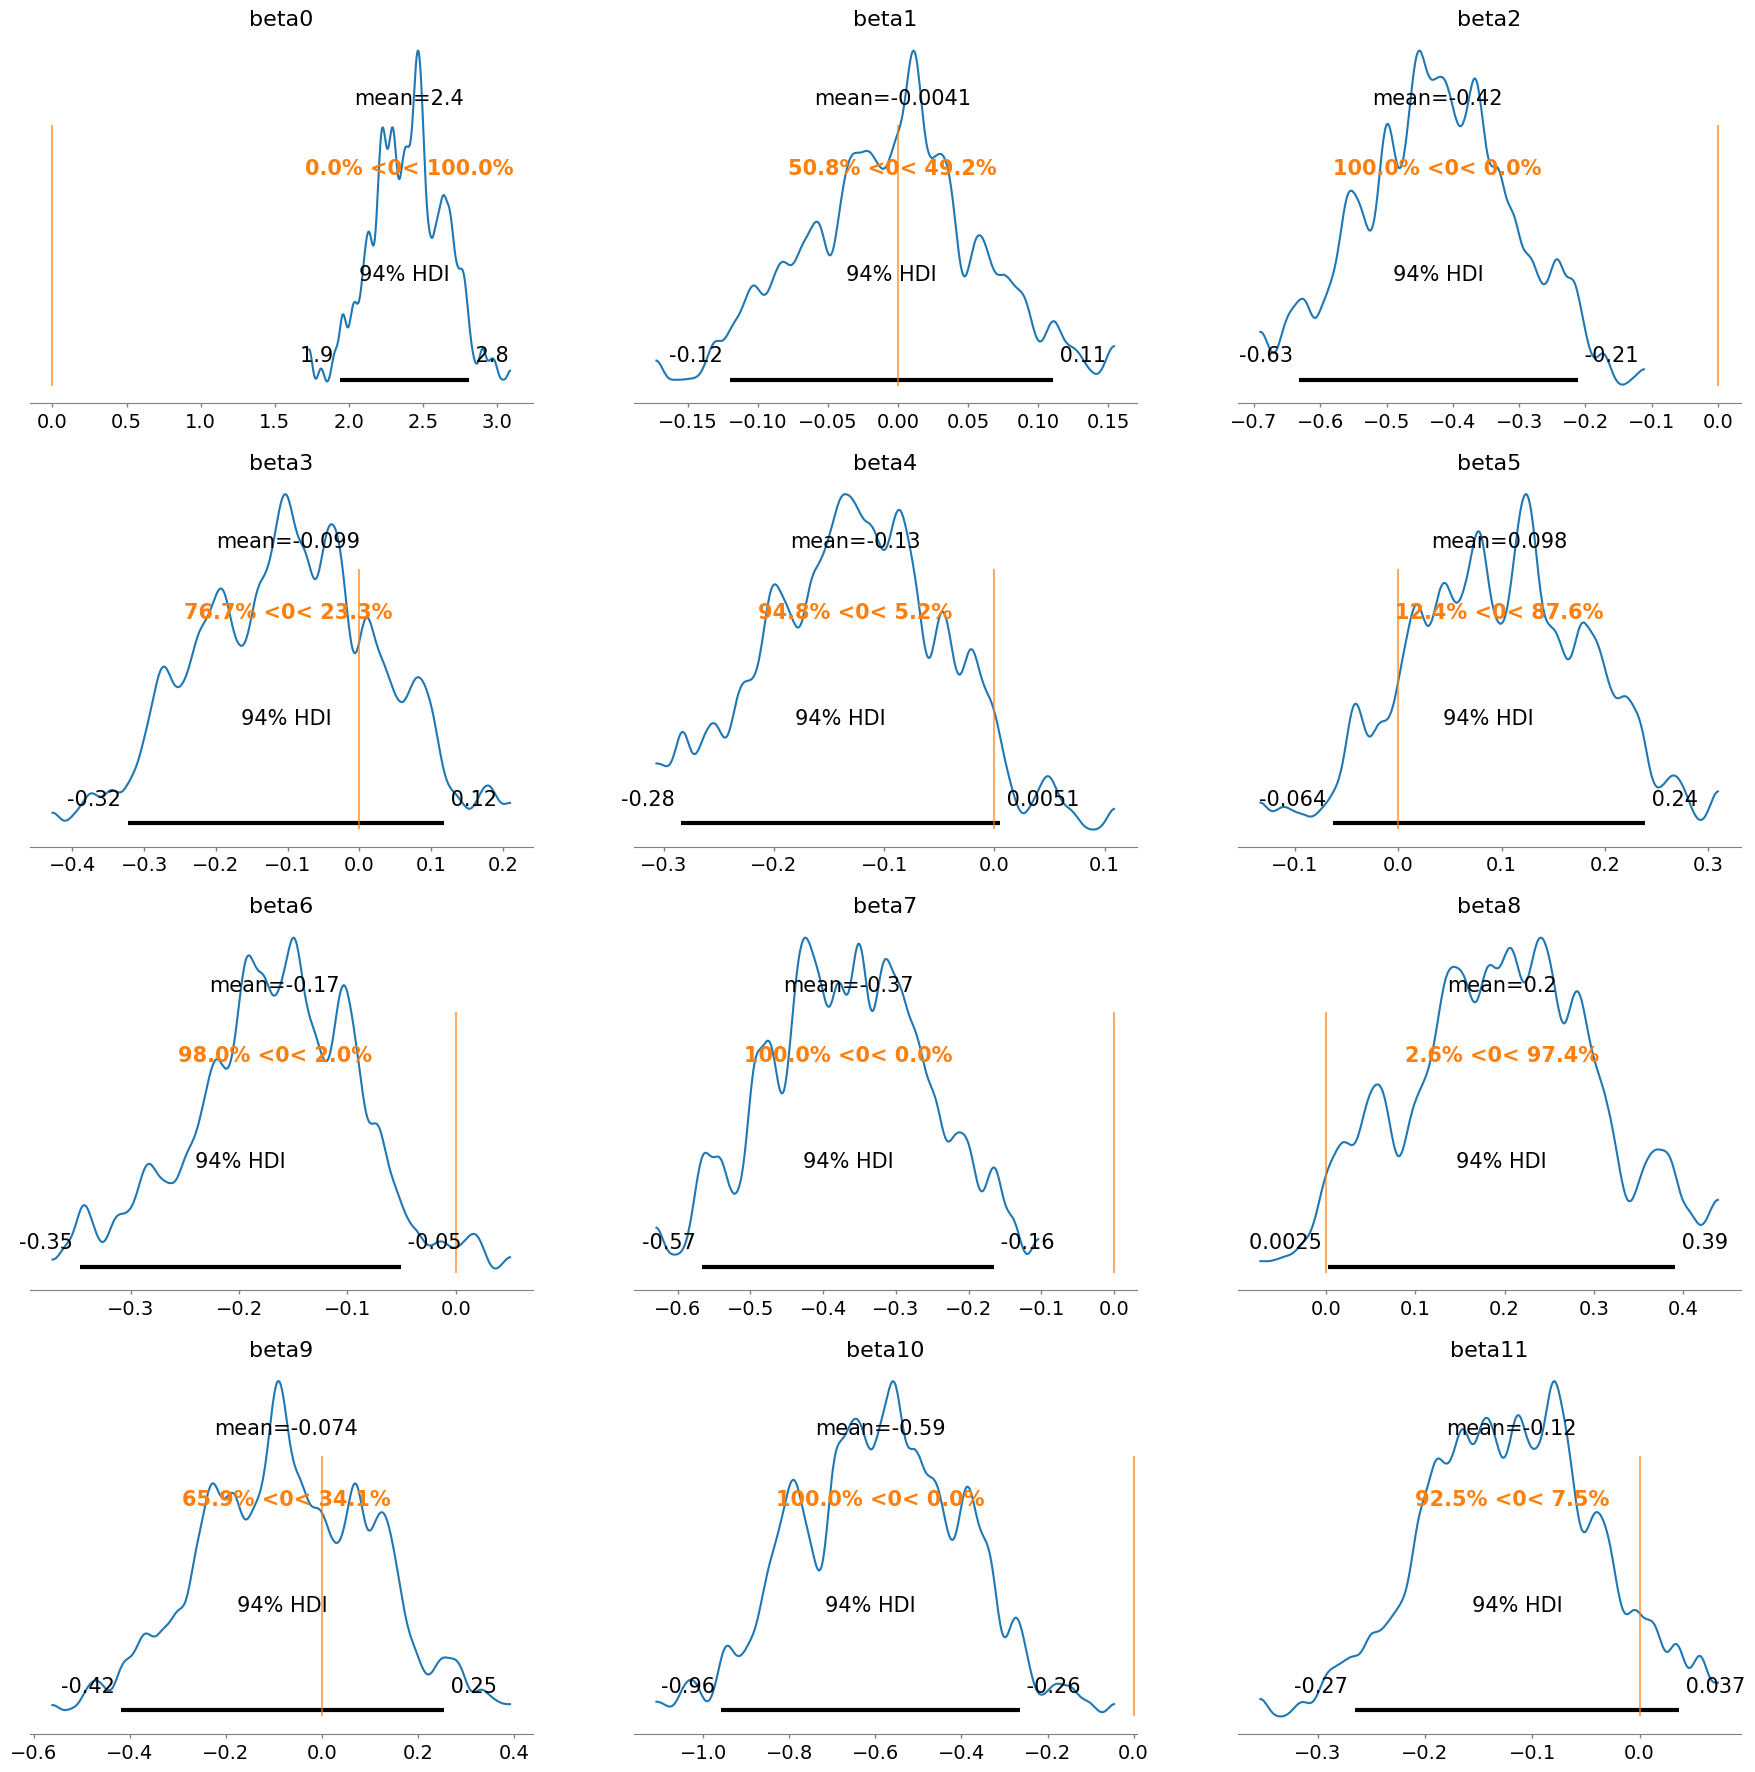

In [46]:
az.plot_posterior(
    algae_svgd_trace,
    var_names = ['beta0', 'beta1','beta2', 'beta3', 'beta4','beta5','beta6','beta7','beta8','beta9','beta10','beta11'], ref_val = 0
)


Based on all of the technqiues used for posterior sampling, HMC with NUTS seems to be the best overall based on a few factors.

The values for the svgd beta estimates appear to not be as smooth as those of the other models. This seems to show that a larger sample size might be necessary for this method to be more effective.

Finally, both the ADVI and the HMC with NUTS both seem to produce satisfactory posterior plots, making it hard to determine which produced the best model. However, the nuts sampler seems to be slightly more accurate (based on HDI) but it is more computationally extenstive, takes more time, and is less scalable.